# Attempt with sklearn's MLPClassifier

In [1]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  
from sklearn.decomposition import PCA
from sklearn.model_selection import ShuffleSplit
from matplotlib import pyplot as plt
import os

In [2]:
my_path = str(os.getcwd())
X_train = np.load(my_path+'/.data/X_train_surge_new.npz')
Y_train = np.array(pd.read_csv(my_path+'/.data/Y_train_surge.csv'))
X_test = np.load(my_path+'/.data/X_test_surge_new.npz')

In [3]:
def surge_prediction_metric(dataframe_y_true, dataframe_y_pred):
    weights = np.linspace(1, 0.1, 10)[np.newaxis]
    surge1_columns = [
        'surge1_t0', 'surge1_t1', 'surge1_t2', 'surge1_t3', 'surge1_t4',
        'surge1_t5', 'surge1_t6', 'surge1_t7', 'surge1_t8', 'surge1_t9' ]
    surge2_columns = [
        'surge2_t0', 'surge2_t1', 'surge2_t2', 'surge2_t3', 'surge2_t4',
        'surge2_t5', 'surge2_t6', 'surge2_t7', 'surge2_t8', 'surge2_t9' ]
    surge1_score = (weights * (dataframe_y_true[surge1_columns].values - dataframe_y_pred[surge1_columns].values)**2).mean()
    surge2_score = (weights * (dataframe_y_true[surge2_columns].values - dataframe_y_pred[surge2_columns].values)**2).mean()

    return surge1_score + surge2_score

def metric_one_surge(y_true,y_pred):
    weights = np.linspace(1, 0.1, 10)[np.newaxis]
    score = (weights*(y_true-y_pred)**2).mean()
    return score

### Utilitary functions for ruling 'weights' issue

In [4]:
# should be applied to Y_train before learning
def transform(y):
    weights = np.sqrt(np.linspace(1, 0.1, 10)[np.newaxis])
    return weights*y

# should be applied to Y_pred after test
def inverse_transform(y):
    weights = 1/np.sqrt(np.linspace(1, 0.1, 10)[np.newaxis])
    return weights*y

## Use MLP only on surge levels

**Goal**: Is part surges data enough to predict the tide ?

#### 1. First city:

In [5]:
# Extract 1st city data
surge1_y_train = transform(np.array(Y_train)[:,1:11])

surge1_x_train = np.array(X_train['surge1_input'])

surge1_x_test = np.array(X_test['surge1_input'])

In [6]:
clf = MLPRegressor(solver='sgd', hidden_layer_sizes=(10,), alpha=1e-5, random_state=1)
clf.fit(surge1_x_train, surge1_y_train)
surge1_y_test = clf.predict(surge1_x_test)

#### 2. Second city:

In [7]:
# Extract 2nd city data
surge2_y_train = transform(np.array(Y_train)[:,11:])

surge2_x_train = np.array(X_train['surge2_input']) 

surge2_x_test = np.array(X_test['surge2_input'])

In [8]:
clf = MLPRegressor(solver='sgd', hidden_layer_sizes=(10,), alpha=1e-5, random_state=1)
clf.fit(surge2_x_train, surge2_y_train)
surge2_y_test = clf.predict(surge2_x_test)

Result of this method: 0.88

Pretty bad, it shows that we need the information of the slp

## Take into account slp

### 1. Dimension reduction of slp data (using PCA)

In [5]:
def slp_to_flat_images(slp):
    a,b,c,d = np.shape(slp)
    return slp.reshape((a*b,c*d))

class Preprocess:
    
    _pca = PCA()
    _scaler1 = StandardScaler()
    _scaler2 = StandardScaler()
    
    def fit_transform(self,slp,nb_comp):
        #reshape
        list_flat_images = slp_to_flat_images(slp)
        # print(list_flat_images.shape)
        #normalize
        list_flat_images = self._scaler1.fit_transform(list_flat_images)
        #fit PCA and transform
        self._pca = PCA(n_components=nb_comp)
        slp_LD = self._pca.fit_transform(list_flat_images)
        #reshape
        slp_LD = np.array([np.concatenate(slp_LD[i*40:(i+1)*40]) for i in range(len(slp))])
        #renormalize
        slp_LD = self._scaler2.fit_transform(slp_LD)
        return slp_LD
    
    def transform(self,slp):
        flat = slp_to_flat_images(slp)
        flat = self._scaler1.transform(flat)
        slp_LD = self._pca.transform(flat)
        slp_LD = np.array([np.concatenate(slp_LD[i*40:(i+1)*40]) for i in range(len(slp))])
        slp_LD = self._scaler2.transform(slp_LD)
        # print(slp_LD.shape)
        # print(slp_LD.shape)
        return slp_LD

In [6]:
prepro = Preprocess()
slp_train_LD = prepro.fit_transform(X_train['slp'], 4)
print(slp_train_LD.shape)

(5599, 160)


In [7]:
slp_test_LD = prepro.transform(X_test['slp'])

### 2. Cross validation

cross validating for one city at a time as we train different models for both

Hyperparameters to test (ordered by priority):
- learning rate
- activation function
- number of dimensions to which we reduce the slp images
- hidden layer size (if we follow the rule of thumb this would be 1 layer with (size(input)+size(output))/2 neurons)

Be carefull to do the preprocess after having split the data into train/test

In [11]:
# prepare validation dataset (extract test from the data we have)
nbs = 5 #number of splits to do the average on
test_s = 0.1 # size of test sample
ss = ShuffleSplit(n_splits=nbs,test_size=test_s)
X_ind = np.zeros(5599)

# function to call for cross validate a parameter
def testParams(city=1, learningRate=1e-5, dimPCA=4, hiddenLayers=(100,)):
    
    errors = []
    
    for s, (train_index, test_index) in enumerate(ss.split(X_ind)):
        print(s)
        #split data
        slp_train = X_train['slp'][train_index]
        slp_test = X_train['slp'][test_index]
        
        surge_input_train = X_train['surge'+str(city)+'_input'][train_index]
        surge_input_test = X_train['surge'+str(city)+'_input'][test_index]
        
        surge_output_train = Y_train[train_index,1:11] if city==1 else Y_train[train_index,11:]
        surge_output_test = Y_train[test_index,1:11] if city==1 else Y_train[test_index,11:]
        
        #preprocessing
        prepro = Preprocess()
        slp_train_LD = prepro.fit_transform(slp_train, dimPCA)
        slp_test_LD = prepro.transform(slp_test)
        
        y_train = transform(surge_output_train)
        
        #concatenate slp and surge input
        x_train = np.concatenate((surge_input_train, slp_train_LD), axis=1)
        x_test = np.concatenate((surge_input_test, slp_test_LD), axis=1)
        
        #learn
        clf = MLPRegressor(solver='sgd', hidden_layer_sizes=hiddenLayers, alpha=learningRate, random_state=1,max_iter=1000)
        clf.fit(x_train,transform(y_train))
        
        #predict
        y_pred = inverse_transform(clf.predict(x_test))
        
        error = metric_one_surge(surge_output_test,y_pred)
        errors.append(error)
        print("error :",error)
    
    return errors    

#### Learning rate optimisation: (Be careful running this cell is veeery long)

In [28]:
alpha = [10**-i for i in range(1,7)]
errs = [testParams(learningRate=a) for a in alpha]
avgerrs = [sum(e)/len(e) for e in errs]

0
error : 0.3177891169196981
1
error : 0.33848202570030994
2
error : 0.3191625961477543
3
error : 0.3404576406605912
4
error : 0.2816579145827894
0
error : 0.33870407284960946
1
error : 0.3452706447738256
2
error : 0.30977539024763323
3
error : 0.30647126274224307
4
error : 0.31251879192593096
0
error : 0.3258594016412289
1
error : 0.34363292888285507
2
error : 0.3096388974734984
3
error : 0.3503411184139953
4
error : 0.3144048986870068
0
error : 0.3262350711197799
1
error : 0.3271050060750535
2
error : 0.31167541656723113
3
error : 0.3299070648981234
4
error : 0.340451001885892
0
error : 0.32881281508496263
1
error : 0.33244198795674873
2
error : 0.30775428212652634
3
error : 0.2932232059055816
4
error : 0.3247841046384451
0
error : 0.31503116372496826
1
error : 0.31443091080645963
2
error : 0.33134109320762656
3
error : 0.3436069377638161
4
error : 0.30388883623396407


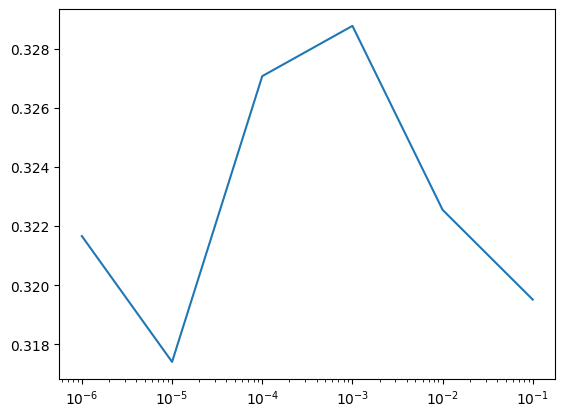

In [30]:
plt.xscale('log', base=10)
plt.plot(alpha,avgerrs)
plt.show()

Conclusion :

Hyperparameters for city 1 :
- alpha = 1e-5

Hyperparameters for city 2 :

### 3. Prediction

#### 1. First city:

In [13]:
# Extract 1st city data
surge1_y_train = transform(np.array(Y_train)[:,1:11])

surge1_input = np.array(X_train['surge1_input'])
surge1_x_train = np.concatenate((surge1_input, slp_train_LD), axis=1)

surge1_x_test = np.concatenate((np.array(X_test['surge1_input']), slp_test_LD), axis=1)

print(surge1_x_train)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 5599 and the array at index 1 has size 5039

In [ ]:
clf = MLPRegressor(solver='sgd', hidden_layer_sizes=(90,), alpha=1e-5, random_state=1,max_iter=1000)
clf.fit(surge1_x_train, surge1_y_train)
surge1_y_test = clf.predict(surge1_x_test)

#### 2. Second city:

In [ ]:
# Extract 2nd city data
surge2_y_train = transform(np.array(Y_train)[:,11:])

surge2_input = np.array(X_train['surge2_input'])
surge2_x_train = np.concatenate((surge2_input, slp_train_LD), axis=1)

surge2_x_test = np.concatenate((np.array(X_test['surge2_input']), slp_test_LD), axis=1)

In [ ]:
clf = MLPRegressor(solver='sgd', hidden_layer_sizes=(90,), alpha=1e-5, random_state=1,max_iter=1000)
clf.fit(surge2_x_train, surge2_y_train)
surge2_y_test = clf.predict(surge2_x_test)

Result:

## Generate output

In [ ]:
# transform clf output
surge_pred = np.concatenate((inverse_transform(surge1_y_test), inverse_transform(surge2_y_test)), axis=1)

In [ ]:
y_columns = [f'surge1_t{i}' for i in range(10)] + [f'surge2_t{i}' for i in range(10)]
Y_pred = pd.DataFrame(data=surge_pred, columns=y_columns, index=X_test['id_sequence'])
Y_pred.to_csv('Y_sep_MLP.csv', index_label='id_sequence', sep=',')